## 11.1 많은 데이터 렌더링하기
- 랙을 경험하도록 데이터 추가
- createBulkTodos 함수를 만들어 데이터 2500개 자동생성
```js
import { useState, useRef, useCallback } from 'react'
import TodoTemplate from "./components/TodoTemplate";
import TodoInsert from "./components/TodoInsert";
import TodoList from "./components/TodoList";

function createBulkTodos() {
  const array = []
  for (let i = 1; i<= 2500; i++) {
    array.push({
      id:i,
      text:`할 일 ${i}`,
      checked:false,
    })
  }
  return array
}

const App = () => {
  const [todos, setTodos ] = useState(createBulkTodos);

  // 고유값 id, ref를 사용해 변수 담기
  const nextId = useRef(4);

  const onInsert = useCallback(
    text => {
      const todo = {
        id : nextId.current,
        text,
        checked:false,
      }
      setTodos(todos.concat(todo))
      nextId.current += 1
    },
    [todos],
  )

  const onRemove = useCallback(
    id => {
      setTodos(todos.filter(todo => todo.id !== id))
    },
    [todos],
  )

  const onToggle = useCallback(
    id => {
      setTodos(
        todos.map(todo =>
          todo.id === id ? { ...todo, checked: !todo.checked } : todo,
        ),
      )
    },
    [todos],
  )

  return (
    <TodoTemplate>
      <TodoInsert onInsert={onInsert}/>
      <TodoList todos={todos} onRemove={onRemove} onToggle={onToggle}/>
    </TodoTemplate>
  )
};

export default App;
```
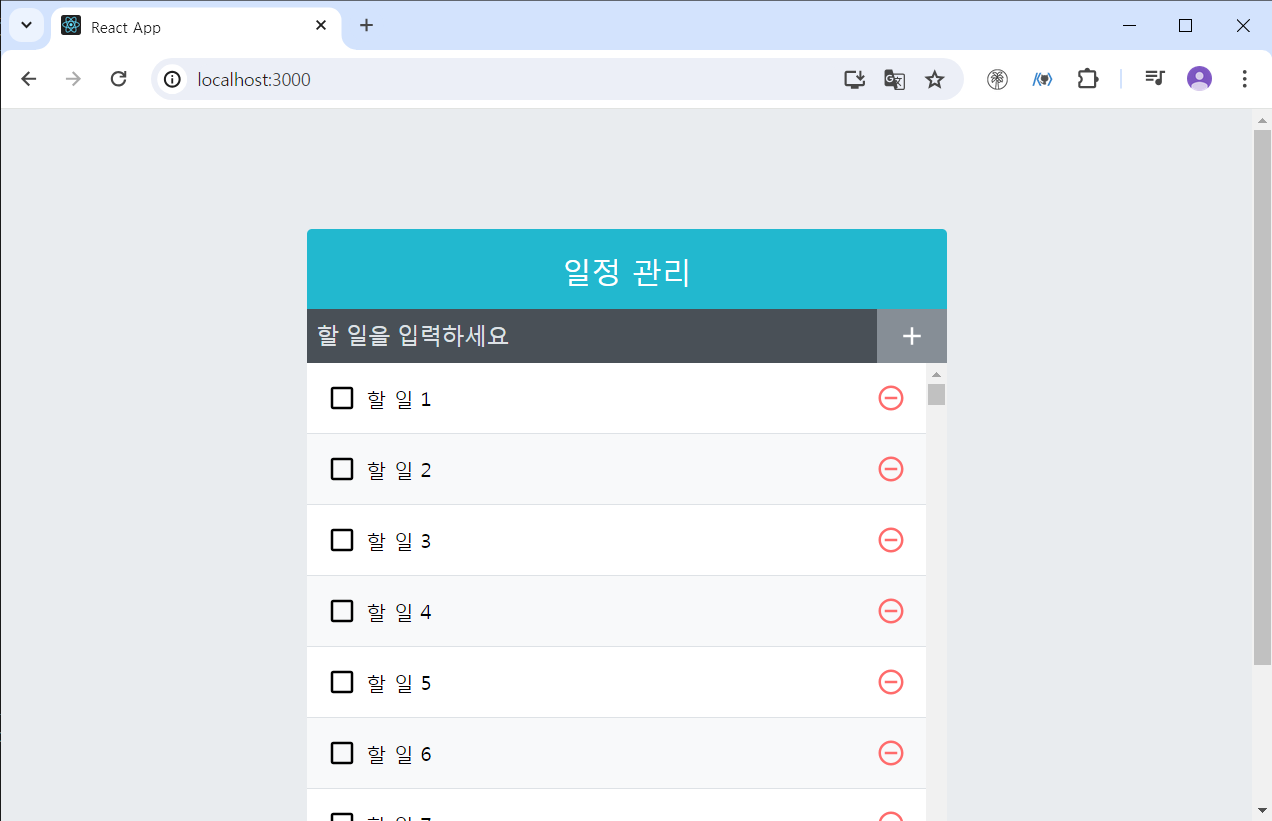

## 11.2 크롬 개발자 도구를 통한 성능 모닝터링
- React DevTools 사용해 성능 분석

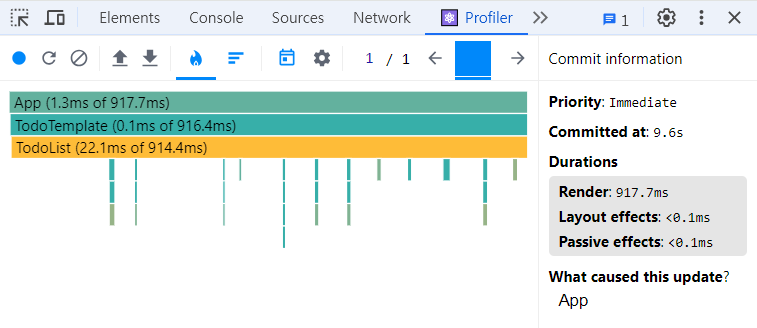

- 변화를 화면에 반영하는데 917.7ms가 걸림

## 11.3 느려지는 원인 분석
- 컴포넌트는 다음과 같은 상황에서 리렌더링이 발생
    1. 자신이 전달받은 props가 변경될 때
    2. 자신의 state가 바뀔 때
    3. 부모 컴포넌트가 리렌더링 될 때
    4. forceUpdate 함수가 실행될 때

- 지금 상황, '할 일 1' 항목을 체크할 경우 App 컴포넌트의 state가 변경되면서 App 컴포넌트가 리렌더링된다.
- 부모 컴포넌트가 리렌더링되었으니 그 안의 무수한 컴포넌트들이 리렌더링 된다.
- '할 일 1' 항목은 리렌더링 되어야 하는 것이 맞지만, '할 일 2'부터 '할 일 2500'가지는 리렌더링 안해도 되는 상황인데 모두 리렌더링 되고 있으므로 느린 것
- 컴포넌트 리렌더링 성능을 최적화 해주는 작업 필요

## 11.4 React.memo를 사용하여 컴포넌트 성능 최적화
- shouldComponentUpdate 라이프 사이클 사용
- 함수 컴포넌트에서는 라이프사이클 메서드를 사용할 수 없다.
- React.memo 함수 사용
    - 컴포넌트의 props가 바뀌지 않았다면, 리렌더링하지 않도록 설정
```js
import React from 'react';
import {
    MdCheckBoxOutlineBlank,
    MdCheckBox,
    MdRemoveCircleOutline,
} from 'react-icons/md';

import cn from 'classnames';
import './TodoListItem.scss';

const TodoListItem = ({todo, onRemove, onToggle}) => {
    const { id, text, checked } = todo
    return (
        <div className='TodoListItem'>
            <div className={cn('checkbox',{checked})} onClick={() => onToggle(id)}>
                {checked ? <MdCheckBox/> : <MdCheckBoxOutlineBlank/>}
                <div className='text'>{text}</div>
            </div>
                <div className="remove" onClick={() => onRemove(id)}>
                <MdRemoveCircleOutline />
            </div>
        </div>
    );
};

export default React.memo(TodoListItem);
```
- 컴포넌트 마지막에 memo로 감싸 주기만 하면 사용 할 수 있다.

## 11.5 onToggle, onRemove 함수가 바뀌지 않게 하기
- useState의 함수형 업데이트
    - 기존에 setTodos 함수를 사용할 때는 새로운 상태를 파라미터로 넣어주었다.
    - setTodos를 사용할때 상태 업데이트를 어떻게 할지 정의해 주는 업데이트 함수를 넣을 수 있다.(함수형 업데이트)
        ```js
        import { useState, useRef, useCallback } from 'react'
        import TodoTemplate from "./components/TodoTemplate";
        import TodoInsert from "./components/TodoInsert";
        import TodoList from "./components/TodoList";

        function createBulkTodos() {
        const array = []
        for (let i = 1; i<= 2500; i++) {
            array.push({
            id:i,
            text:`할 일 ${i}`,
            checked:false,
            })
        }
        return array
        }

        const App = () => {
        const [todos, setTodos ] = useState(createBulkTodos);

        // 고유값 id, ref를 사용해 변수 담기
        const nextId = useRef(4);

        const onInsert = useCallback(
            text => {
            const todo = {
                id : nextId.current,
                text,
                checked:false,
            }
            setTodos(todos => todos.concat(todo))
            nextId.current += 1
            },
            [],
        )

        const onRemove = useCallback(
            id => {
            setTodos(todos => todos.filter(todo => todo.id !== id))
            },
            [],
        )

        const onToggle = useCallback(
            id => {
            setTodos(todos =>
                todos.map(todo =>
                todo.id === id ? { ...todo, checked: !todo.checked } : todo,
                ),
            )
            },
            [],
        )

        return (
            <TodoTemplate>
            <TodoInsert onInsert={onInsert}/>
            <TodoList todos={todos} onRemove={onRemove} onToggle={onToggle}/>
            </TodoTemplate>
        )
        };

        export default App;
        ```

        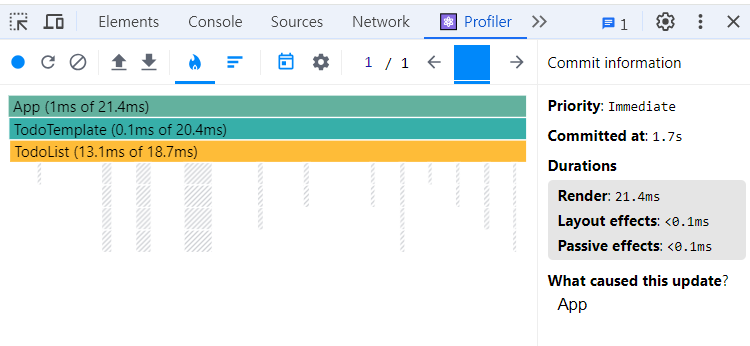

        - 성능 향상 확인 가능 
        - 렌더링 시간이 21.4ms로 감소
    - useReducer 사용
        ```js
        import { useReducer , useRef, useCallback } from 'react'
        import TodoTemplate from "./components/TodoTemplate";
        import TodoInsert from "./components/TodoInsert";
        import TodoList from "./components/TodoList";

        function createBulkTodos() {
        const array = []
        for (let i = 1; i<= 2500; i++) {
            array.push({
            id:i,
            text:`할 일 ${i}`,
            checked:false,
            })
        }
        return array
        }

        function todoReducer(todos, action){
        switch (action.type){
            case 'INSERT':
            return todos.concat(action.todo)
            case 'REMOVE':
            return todos.filter(todo => todo.id !== action.id)
            case 'TOGGLE':
            return todos.map(todo =>
                todo.id === action.id ? { ...todo, checked: !todo.checked } : todo,
            )
            default:
            return todos;
        }
        }

        const App = () => {
        const [todos, dispatch] = useReducer(todoReducer, undefined, createBulkTodos)

        // 고유값 id, ref를 사용해 변수 담기
        const nextId = useRef(4);

        const onInsert = useCallback(
            text => {
            const todo = {
                id : nextId.current,
                text,
                checked:false,
            }
            dispatch({type:'INSERT', todo})
            nextId.current += 1
            },
            [],
        )

        const onRemove = useCallback(
            id => {
            dispatch({type:'REMOVE', id})
            },
            [],
        )

        const onToggle = useCallback(id => {
            dispatch({type:'TOGGLE', id})
        }, [])

        return (
            <TodoTemplate>
            <TodoInsert onInsert={onInsert}/>
            <TodoList todos={todos} onRemove={onRemove} onToggle={onToggle}/>
            </TodoTemplate>
        )
        };

        export default App;
        ```
        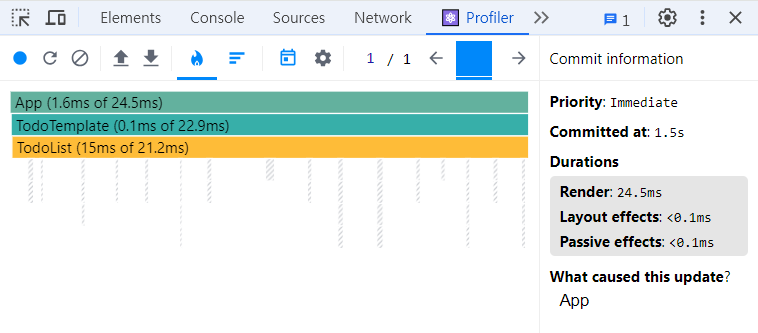
        - 렌더링 시간이 24.5ms로 감소
        - useReducer를 사용할 때는 두 번째 파라미터에 초기 상태를 넣어주어야 한다.
        - 지금은 두 번째 파라미터에 undefined를 넣고, 세 번째 파라미터에 초기 상태를 만들어 주는 함수인 createBulkTodos를 넣었다.
        - 컴포넌트가 맨 처음 렌더링될 때만 createBulkTodos 함수가 호출된다
        - 기존 코드를 많이 고쳐야 한다는 단점이 있다
        - 하지만 상태 업데이트하는 로직을 모아 컴포넌트 바깥에 둘 수 있다는 장점이 있다.
        


## 11.6 불변성의 중요성
- useState를 사용해 만든 todos 배열과 setTodos 함수를 사용하는 onToggle 함수
    ```js
    const onToggle = useCallback(id => {
        setTodos(todos =>
            todos.map(todo =>
                    todo.id === id ? { ...todo, checked: !todo.checked } : todo,
                ),
            )
        },[],)
    ```
- 기존 데이터를 수정할 때 직접 수정하지 않고, 새로운 배열을 만든 다음 새로운 객체를 만들어 필요한 부분을 교체하는 방식으로 구현
- 업데이트가 필요한 곳에서는 아예 새로운 배열 혹은 새로운 객체를 만들기 때문에, React.memo를 사용했을 때 props가 바뀌었는지, 바뀌지 않았는지 알아내 최적화해줄 수 있다.
- 불변성을 지킨다
- 불변성이 지켜지지 않으면 객체 내부의 값이 새로워져도 바뀐 것을 감지하지 못한다.
    

## 11.7 TodoList 컴포넌트 최적화 하기
```js
import React from 'react'
import TodoListItem from './TodoListItem';
import './TodoList.scss';

const TodoList = ({ todos, onRemove, onToggle }) => {
    return (
        <div className='TodoList'>
            {todos.map(todo => (
                <TodoListItem todo={todo} key={todo.id} onRemove={onRemove} onToggle={onToggle}/>
            ))}            
        </div>
    );
};

export default React.memo(TodoList);
```
- 현재 프로젝트 성능에 전혀 영향을 주지 않는다.
- TodoList 컴포넌트의 부모 컴포넌트인 App 컴포넌트가 리렌더링되는 유일한 이유가 todos 배열이 업데이트 될 때이기 때문
- 즉 TodoList 컴포넌트는 불필요한 리렌더링이 발생하지 않음
- 리스트 관련 컴포넌트를 작성할 때 리스트 아이템, 리스트 두 가지 컴포넌트를 최적화해주어야 한다
    - 내부 데이터가 100개를 넘지 않거나 업데이트가 자주 발생하지 않는다면, 최적화 작업을 반드시 해 줄 필요는 없다.

## 11.8 react-virtualized를 사용한 렌더링 최적화
- react-virtualized
    - 리스트 컴포넌트에서 스크롤되기 전에 보이지 않는 컴포넌트는 렌더링하지 않고 크기만 차지하게끔 한다.
    - 만약 스크롤되면 해다 스크롤 위치에서 보여 주어야 할 컴포넌트를 자연스럽게 렌더링한다.
    - yarn add react-virtualized
    - 각 항목의 실제 크기를 px 단위로 알아야 한다
    
        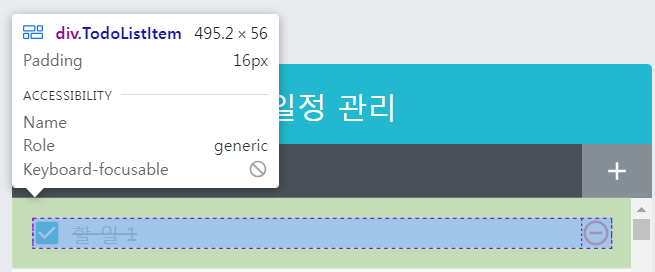
    - 가로 495.2px 세로 56px 
- TodoList 수정
    - List 컴포넌트를 사용하기 위해 rowRenderer 함수 작성
    - react-virtualized의 List 컴포넌트에서 각 TodoItem을 렌더링 할 때 사용, 이 함수를 List 컴포넌트 props로 설정
    - 해당 리스트의 전체 크기와 각 항목 높이, 렌더링 할 때 사용하는 함수, 배열을 props로 넣어주면 자동으로 최적화
    ```js
    import React, { useCallback } from 'react'
    import { List } from 'react-virtualized'
    import TodoListItem from './TodoListItem';
    import './TodoList.scss';

    const TodoList = ({ todos, onRemove, onToggle }) => {
        const rowRenderer = useCallback(
            ({ index, key, style }) => {
                const todo = todos[index]
                return(
                    <TodoListItem
                        todo={todo}
                        key={key}
                        onRemove={onRemove}
                        onToggle={onToggle}
                        style={style}
                    />
                )
            },
            [onRemove, onToggle, todos],
        )

        return (
            <List
                className='TodoList'
                // 전체 크기
                width={512}
                // 전체 높이
                height={513}
                // 항목 개수
                rowCount={todos.length}
                // 항목 높이
                rowHeight={57}
                // 항목을 렌더링할 때 쓰는 함수
                rowRenderer={rowRenderer}
                // 배열
                list={todos}
                // list에 기본 적용되는 outline 스타일 제거
                style={{outline:'none'}}
            />
        );
    };

    export default React.memo(TodoList);
    ```
- TodoListItem 수정
    - render 함수에서 기존에 보여 주던 내용을 div로 감싸고, style 적용
        ```js
        import React from 'react';
        import {
            MdCheckBoxOutlineBlank,
            MdCheckBox,
            MdRemoveCircleOutline,
        } from 'react-icons/md';

        import cn from 'classnames';
        import './TodoListItem.scss';

        const TodoListItem = ({todo, onRemove, onToggle, style}) => {
            const { id, text, checked } = todo
            return (
                <div className='TodoListItem-virtualized' style={style}>
                    <div className='TodoListItem'>
                        <div className={cn('checkbox',{checked})} onClick={() => onToggle(id)}>
                            {checked ? <MdCheckBox/> : <MdCheckBoxOutlineBlank/>}
                            <div className='text'>{text}</div>
                        </div>
                            <div className="remove" onClick={() => onRemove(id)}>
                            <MdRemoveCircleOutline />
                        </div>
                    </div>
                </div>
            );
        };

        export default React.memo(TodoListItem);
        ```

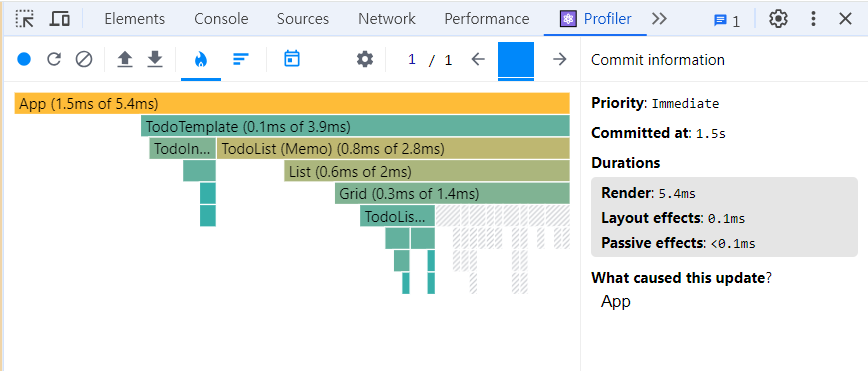

- 성능이 5.4ms까지 줄은 것을 확인 가능

## 11.9 정리
- 리액트 애플리케이션에 많은 데이터를 렌더링하는 리스트를 만들어 지연을 유발
- 이를 해결하는 방법을 알아봄
- 기본적으로는 최적화 작업을 신경 쓸 필요 없다
- 리스트와 관련된 컴포넌트를 만들 때 보여 줄 항목이 100개 이상이고 업데이트가 자주 발생한다면 꼭 최적화해야한다